## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys, logging

logging.basicConfig(
        level=logging.INFO,
        stream=sys.stdout,
        format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
        force=True,
    )

In [3]:
import gc

from scipy.stats import norm
import math

import numpy as np
import pandas as pd
import torch


from tqdm import tqdm
import time

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    # torch.set_default_tensor_type("torch.cuda.DoubleTensor")
    device = "cuda"

else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"

/Users/tomasz.kusmierczyk/venv_torch/lib/python3.8/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [5]:
# torch.set_default_tensor_type("torch.FloatTensor")
# device = "cpu"

In [6]:
print(f"Used device = {device}")

Used device = cpu


In [7]:
sys.path.append("../")

import reparameterized
from reparameterized import sampling

In [8]:
from data.minibatches import generate_minibatches, iterate_over_minibatches
from aux.gpu import gpu_memory_info_smi

import import_export

In [9]:
from weights_sampling.hypernet_gaussian_priors import nll_factorized_gaussian_with_hypernet_params

## Config

In [10]:
import args as args_loading

# used when run from command line
args = args_loading.parse_args()
# print(f"Parsing args = {args}")

In [11]:
random_seed = args.get("random_seed", 0)

In [12]:
train_data_proportion = args.get("train_data_proportion", 6 / 9)


# NF 
nf_model = args.get("nf_model", 0) 
realnvp_rezero = args.get("realnvp_rezero", False)
realnvp_num_layers = args.get("realnvp_num_layers", 32)
realnvp_m_multiplier = args.get("realnvp_m_multiplier", 6)

# NF posterior training
stl_gradient_estimator = False
n_epochs = args.get("n_epochs", 1500)
batch_size = args.get("batch_size", 1024*10)
n_posterior_samples_total = args.get("n_posterior_samples_total", 128)

optimizer = args.get("optimizer", "adam")
optimizer_lr = args.get("optimizer_lr", 0.0001)
prior_lengthscale_lr = args.get("prior_lengthscale_lr", optimizer_lr)
observation_noise_scale_lr = args.get("observation_noise_scale_lr", optimizer_lr)
early_stopping_n_iters = args.get("early_stopping_n_iters", 100)

beta = args.get("beta", 1.0)
beta_annealing = args.get("beta_annealing", False)
beta_annealing_iterations = args.get("beta_annealing_iterations", 200)

report_every_n_iterations = args.get("report_every_n_iterations", 200)
eval_n_samples = args.get("eval_n_samples", 1024)

In [13]:
observation_noise_scale = args.get("observation_noise_scale", 0.05)
learn_observation_noise_scale = args.get("learn_observation_noise_scale", False)

prior_lengthscale = args.get("prior_lengthscale", 1.0)
learn_prior_lengthscale = args.get("learn_prior_lengthscale", False)

prior_fit_result = args.get(
    "prior",
    "../results/experiment_house_electric_fit_hypernet_prior_20250127113214/house_electric_fit_hnet_cf2_s0_results.json.gz",
)

datafile = "../data/uci_household_power_consumption/individual+household+electric+power+consumption.npy"

In [14]:
observation_noise_scale = torch.tensor(observation_noise_scale, requires_grad=learn_observation_noise_scale)
prior_lengthscale = torch.tensor(prior_lengthscale, requires_grad=learn_prior_lengthscale)

In [15]:
output_prefix = args.get("run_name", "house_electric_fit_posterior_hypernet_vi")+"_"

In [16]:
# args["smoke_test"] = True

In [17]:
if args.get("smoke_test", False):
    nf_model = 1
    n_epochs = 3
    report_every_n_iterations = 2
    n_posterior_samples_total = 3
    eval_n_samples = 6
    batch_size = 1024*10
    
    learn_observation_noise_scale = True
    observation_noise_scale_lr = 10*optimizer_lr
    learn_prior_lengthscale = True
    prior_lengthscale_lr = 10*optimizer_lr

In [18]:
print(f"Configuration = {locals()}")

Configuration = {'__name__': '__main__', '__doc__': 'Automatically created module for IPython interactive environment', '__package__': None, '__loader__': None, '__spec__': None, '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '_ih': ['', "get_ipython().run_line_magic('reload_ext', 'autoreload')\nget_ipython().run_line_magic('autoreload', '2')", 'import sys, logging\n\nlogging.basicConfig(\n        level=logging.INFO,\n        stream=sys.stdout,\n        format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",\n        force=True,\n    )', 'import gc\n\nfrom scipy.stats import norm\nimport math\n\nimport numpy as np\nimport pandas as pd\nimport torch\n\n\nfrom tqdm import tqdm\nimport time', 'if torch.cuda.is_available():\n    torch.set_default_tensor_type("torch.cuda.FloatTensor")\n    # torch.set_default_tensor_type("torch.cuda.DoubleTensor")\n    device = "cuda"\n\nelse:\n    torch.set_default_tensor_type("torch.Flo

## Load and preprocess data.

In [19]:
from data.uci_household_power_consumption import load as data_src

In [20]:
(
    x_train,
    y_train,
    x_test,
    y_test,
    y_train_r_mean,
    y_train_r_std,
    tt_split_hsh,
) = data_src.prepare_data(datafile=datafile, train_prop=train_data_proportion)
print("data:", x_train.shape, y_train.shape, x_test.shape, y_test.shape, y_train_r_mean, y_train_r_std, tt_split_hsh)

data: torch.Size([1366186, 8]) torch.Size([1366186]) torch.Size([683094, 8]) torch.Size([683094]) tensor(9.3178) tensor(9.5873) 9d025f6b9a0637a8e6858f9ad33f3a12


In [21]:
# Data to torch tensors for training
training_data = x_train
training_targets = y_train

train_x = training_data.to(device)
train_y = training_targets.to(device)
x_test =  x_test.to(device)
y_test =  y_test.to(device)

In [22]:
gc.collect()
gpu_memory_info_smi()

nvidia-smi not found. Ensure NVIDIA drivers are installed and accessible.
[2025-01-30 16:44:36,647] {../aux/gpu.py:63} INFO - [gpu_memory_info_smi] No GPU information available.


## BNN

In [23]:
def log_likelihood(bnn, activation, train_x, train_y, observation_noise_scale):
    pred_means = bnn(train_x, activation)
    log_probs = torch.distributions.Normal(
        pred_means.flatten(), observation_noise_scale
    ).log_prob(train_y.flatten())
    return log_probs

In [24]:
import import_export 

prior_params = import_export.load_from_json(prior_fit_result)

conditional_activation = prior_params["parameters"]["activation"].to(device)
hypernet = prior_params["parameters"]["hypernet"].to(device)
hypernet.requires_grad_(False)

bnn = prior_params["net"].to(device)
net_width = prior_params["net_width"]

[2025-01-30 16:44:36,854] {../import_export.py:77} WARNING - Failed loading create_target_generator = {'name': '<function create_target_generator at 0x7ab1a5b28ee0>', 'type': 'pickle', 'pickle': 'gASVKAAAAAAAAACMCF9fbWFpbl9flIwXY3JlYXRlX3RhcmdldF9nZW5lcmF0b3KUk5Qu'}: Can't get attribute 'create_target_generator' on <module '__main__'>
[2025-01-30 16:44:37,449] {../import_export.py:77} WARNING - Failed loading create_training_grid = {'name': '<function create_training_grid at 0x7ab1a5b28550>', 'type': 'pickle', 'pickle': 'gASVJQAAAAAAAACMCF9fbWFpbl9flIwUY3JlYXRlX3RyYWluaW5nX2dyaWSUk5Qu'}: Can't get attribute 'create_training_grid' on <module '__main__'>
[2025-01-30 16:44:37,450] {../import_export.py:77} WARNING - Failed loading create_target_generator = {'name': '<function create_target_generator at 0x7ab1a5b28ee0>', 'type': 'pickle', 'pickle': 'gASVKAAAAAAAAACMCF9fbWFpbl9flIwXY3JlYXRlX3RhcmdldF9nZW5lcmF0b3KUk5Qu'}: Can't get attribute 'create_target_generator' on <module '__main__'>


In [25]:
conditional_activation.requires_grad_(False)
for name, param in conditional_activation.named_parameters():
    print(f"turning off gradient for conditional_activation.{name}")
    param.requires_grad = False

turning off gradient for fc1.weight
turning off gradient for fc1.bias


In [26]:
hypernet.requires_grad_(False)
for name, param in hypernet.named_parameters():
    print(f"turning off gradient for hypernet.{name}")
    param.requires_grad = False

turning off gradient for hidden_layers.0.weight
turning off gradient for hidden_layers.0.bias
turning off gradient for hidden_layers.2.weight
turning off gradient for hidden_layers.2.bias
turning off gradient for hidden_layers.4.weight
turning off gradient for hidden_layers.4.bias
turning off gradient for output_layers.0.weight
turning off gradient for output_layers.0.bias
turning off gradient for output_layers.1.weight
turning off gradient for output_layers.1.bias
turning off gradient for output_layers.2.weight
turning off gradient for output_layers.2.bias


In [27]:
def log_priors(bnn, prior_params, samples):
    samples_nlls = nll_factorized_gaussian_with_hypernet_params(bnn.named_parameters(), prior_params, samples)
    return sum(-nlls for nlls in samples_nlls.values())  # sum over model parameters => output shape (n_samples, )

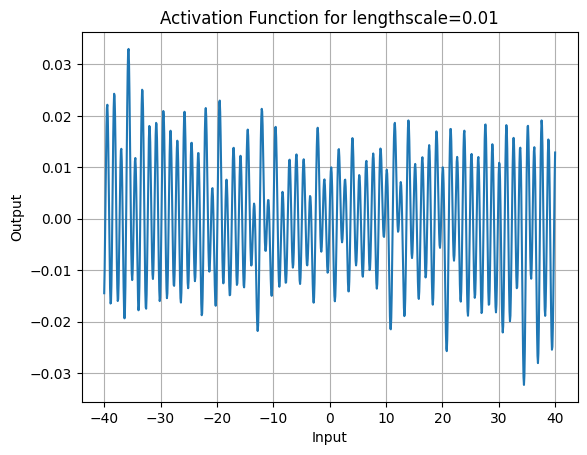

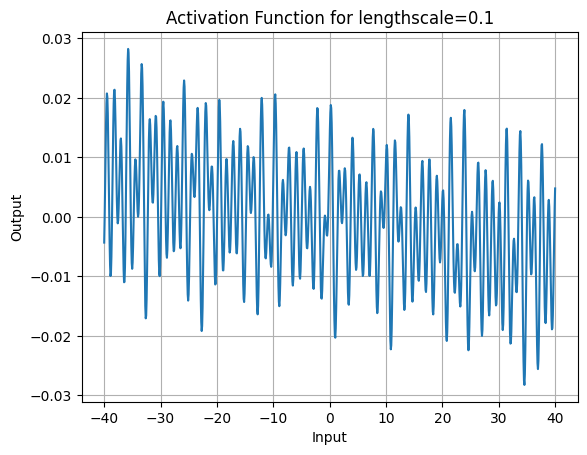

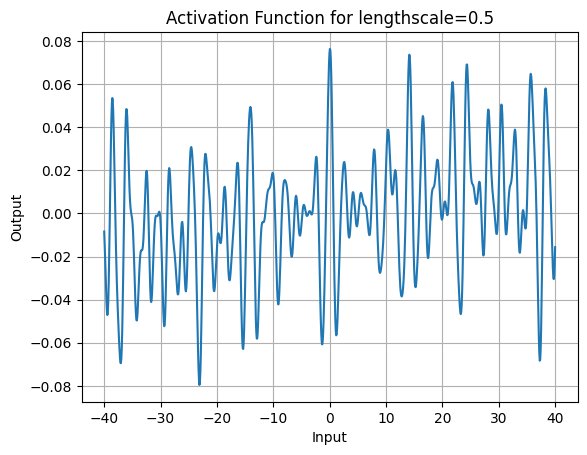

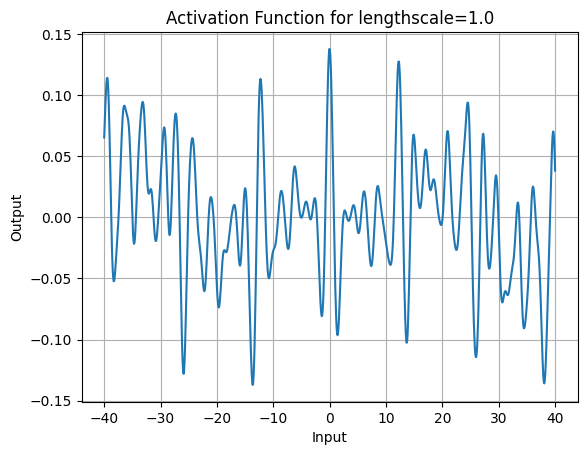

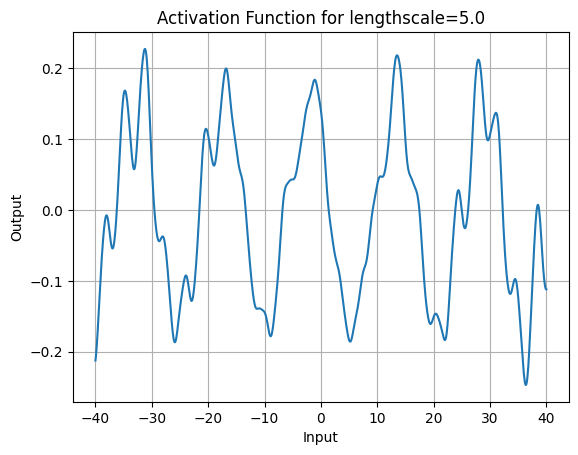

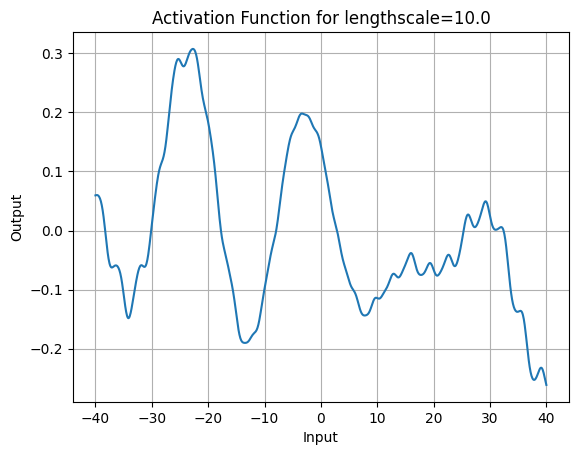

In [28]:
try:
    from matplotlib import pyplot as plt

    for lengthscale in [0.01, 0.1, 0.5, 1.0, 5., 10.]:

        hypernet_input = torch.tensor(lengthscale)
        hypernet_output = hypernet(hypernet_input)
        activation_params = hypernet_output[:-1]
        actviation = lambda a: conditional_activation(a, activation_params)

        x = torch.linspace(-40, 40, 1000)
        y = actviation(x).detach().cpu().numpy()

        plt.plot(x.detach().cpu().numpy(), y)
        plt.title(f"Activation Function for lengthscale={lengthscale}")
        plt.xlabel("Input")
        plt.ylabel("Output")
        plt.grid(True)
        plt.show()
except Exception as e:
    print(e)

### Evaluation

In [29]:
def sample_from_predictive(
    bnn,
    activation,
    sampler,
    x,
    n_samples=1024,
    n_samples_per_sampling=128,
    batch_size=1024,
    verbose=False,
    **kwargs,
):
    """ Generate n_samples of prediction means using the sampler function."""
    
    n_samples_per_sampling = min(n_samples_per_sampling, n_samples)
    assert (
        n_samples % n_samples_per_sampling == 0
    ), "n_samples_per_sampling must divide n_samples"

    preds = []
    progress_tracking = lambda i: i
    if verbose:
        logging.info(
            f"[get_predicitive] generating n_samples={n_samples} "
            f"n_samples_per_sampling={n_samples_per_sampling} "
            f"minibatch_size={batch_size}"
        )
        progress_tracking = tqdm
    for _ in progress_tracking(range(n_samples // n_samples_per_sampling)):
        samples, _ = sampler(n_samples_per_sampling)

        for s in reparameterized.take_parameters_sample(samples):
            reparameterized.load_state_dict(bnn, s)

            pred = []
            for x1 in iterate_over_minibatches(x, batch_size=batch_size):
                pred1 = bnn(x1, activation)
                pred.append(pred1)
            pred = torch.concat(pred)

            preds.append(pred)

    preds = torch.stack(preds)[:, :, 0]
    assert preds.shape == torch.Size(
        [n_samples, x.shape[0]]
    ), f"preds.shape={preds.shape} vs {n_samples, x.shape[0]}"

    return preds

In [30]:
@torch.no_grad()
def negative_log_likelihood(train_y, mu_samples, observation_noise_scale, agg=None):
    """Calculate the negative log likelihood for the given dataset."""
    n_samples = mu_samples.size(0)
    n_train = train_y.size(0)
    
    # Create a normal distribution with the given mean and observation noise
    d = torch.distributions.Normal(mu_samples, observation_noise_scale)
    
    # Compute the log probabilities of the training data under this distribution
    log_probs = d.log_prob(train_y.unsqueeze(0).expand(n_samples, n_train))
    
    # Average the log probabilities over the samples
    avg_log_probs = torch.logsumexp(log_probs, dim=0) - math.log(n_samples)
    
    # Sum the -log probabilities to get the negative log likelihood
    return -avg_log_probs if agg is None else agg(-avg_log_probs)


@torch.no_grad()
def negative_log_likelihood_gaussian(train_y, mu_samples, observation_noise_scale, agg=None):
    """Calculates the negative log likelihood of Gaussian distribution."""
    
    y, mu, var = train_y, mu_samples.mean(0), mu_samples.var(0)+observation_noise_scale**2
    
    y, mu, var = y.squeeze(), mu.squeeze(), var.squeeze()
    nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))

    return torch.tensor(nll) if agg is None else agg(nll)

In [31]:
@torch.no_grad()
def eval_bnn(
    x_test, y_test, bnn, activation, sampler, observation_noise_scale, **kwargs
):
    gc.collect()

    pred_mean_samples = sample_from_predictive(
        bnn, activation, sampler, x_test, **kwargs
    )
    gc.collect()

    nlls = []
    nlls_g = []
    data_size = len(y_test)
    for pred_mean_samples1, y_test1 in iterate_over_minibatches(
        pred_mean_samples.T, y_test, 10 * 1024
    ):
        pred_mean_samples1 = pred_mean_samples1.T

        nll = negative_log_likelihood(
            y_test1.flatten(), pred_mean_samples1, observation_noise_scale
        )
        nlls.append(nll)

        nll_g = negative_log_likelihood_gaussian(
            y_test1.flatten(), pred_mean_samples1, observation_noise_scale
        )
        nlls_g.append(nll_g)

    nlls_g = torch.cat(nlls_g)
    assert nlls_g.shape == torch.Size([data_size])
    nll_g = nlls_g.mean()  # average over data points

    nlls = torch.cat(nlls)
    assert nlls.shape == torch.Size([data_size])
    nll = nlls.mean()  # average over data points

    preds_avg_mean = pred_mean_samples.mean(axis=0)
    rmse = torch.sqrt(((preds_avg_mean - y_test) ** 2).mean())

    gc.collect()
    return {"rmse": rmse.item(), "nll_g": nll_g.item(), "nll": nll.item()}

### Network

In [32]:
indim = x_train.shape[-1]
print(bnn)

SingleHiddenLayerWideNNWithLearnablePriorsAndActivation(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


### Posterior Sampler = Normalizing Flow

In [33]:
torch.manual_seed(random_seed)

In [34]:
bnn_learning_params = {n: p for n,p in bnn.named_parameters() if "activation" not in n}  # exclude activation params
print(f"bnn_learning_params = {bnn_learning_params.keys()}")

bnn_learning_params = dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


In [35]:
if nf_model==0:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        bnn_learning_params,
        build_flow_func = sampling.realnvp.build_realnvp,
        realnvp_rezero=realnvp_rezero,
        realnvp_num_layers=realnvp_num_layers,
        realnvp_m=int(realnvp_m_multiplier*net_width),
        )
    n_posterior_samples = n_posterior_samples_total  # in one forward operation
    
elif nf_model==1:
    sampler, variational_params, aux_objs = sampling.create_multiparameter_sampler_dict(
        sampling.create_flow_sampler,
        bnn_learning_params,
        build_flow_func = sampling.realnvp.build_realnvp,
        realnvp_rezero=realnvp_rezero,
        realnvp_num_layers=2,
        realnvp_m=32,
        )
    n_posterior_samples = n_posterior_samples_total  # in one forward operation
    
    
else:
    raise ValueError(f"Wrong value of nf_model={nf_model}!")

In [36]:
print("flow=", aux_objs["flow"])

flow= RealNVP(
  (t): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=641, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=640, bias=True)
    )
  )
  (s): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=641, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=640, bias=True)
      (5): Tanh()
    )
  )
)


In [37]:
gpu_memory_info_smi()

nvidia-smi not found. Ensure NVIDIA drivers are installed and accessible.
[2025-01-30 16:44:38,920] {../aux/gpu.py:63} INFO - [gpu_memory_info_smi] No GPU information available.


In [38]:
start_time = time.time()
samples, q_nlls = sampler(1)
print(f"sampled 1 sample in {time.time()-start_time: .2f}s")

s1 = next(reparameterized.take_parameters_sample(samples))
n_parameters = sum(s.numel() for s in s1.values())
print(f"n_parameters = {n_parameters}")

n_variational_params = sum(p.numel() for p in variational_params.values())
print(f"n_variational_params = {n_variational_params}")

sampled 1 sample in  0.00s
n_parameters = 1281
n_variational_params = 170880


In [39]:
print("samples=", samples, "q_nlls=", q_nlls)

samples= {'fc1.weight': tensor([[[-8.1740e-01, -8.5755e-04, -5.8106e-01,  ...,  8.3026e-01,
          -1.9300e+00,  3.0158e-01],
         [ 5.5393e-01, -9.3305e-01, -5.4873e-01,  ..., -1.2243e+00,
           1.8156e-01, -1.1209e+00],
         [ 3.4224e-01,  6.0895e-01, -2.1537e+00,  ...,  5.1084e-01,
          -3.9436e-02, -9.9458e-01],
         ...,
         [-7.6508e-02,  2.2891e-01, -3.1636e-01,  ..., -5.1325e-01,
          -5.0327e-01, -1.2185e+00],
         [-6.6813e-01, -7.9126e-01, -7.1559e-01,  ...,  7.3966e-02,
          -7.2773e-01,  1.5458e+00],
         [-4.1290e-02, -2.7823e-01, -1.9540e+00,  ...,  1.8924e-01,
           3.3078e-01,  1.4858e+00]]], grad_fn=<ViewBackward0>), 'fc1.bias': tensor([[ 1.0218e+00,  7.2178e-01,  7.6098e-02,  2.9261e-01, -1.0985e-01,
          1.2937e+00,  1.8952e-02, -1.5611e+00,  3.5420e-01,  1.0778e+00,
         -2.9035e-01,  1.5542e+00,  1.4248e+00,  9.2952e-01, -3.9499e-01,
          2.7817e-02,  3.7878e-01, -3.7694e+00,  1.0431e+00,  1.6929e+

In [40]:
print(f"Using device: samples={next(iter(samples.values())).device} train_x={train_x.device}")

Using device: samples=cpu train_x=cpu


In [41]:
gc.collect()
gpu_memory_info_smi()

nvidia-smi not found. Ensure NVIDIA drivers are installed and accessible.
[2025-01-30 16:44:39,212] {../aux/gpu.py:63} INFO - [gpu_memory_info_smi] No GPU information available.


In [42]:
# start_time = time.time()
# n_samples = 20
# samples, q_nlls = sampler(n_samples)
# print(f"sampled {n_samples} samples in {time.time()-start_time: .2f}s")

#### Training ELBO

In [43]:
hypernet_input = prior_lengthscale
activation_params = hypernet(hypernet_input)[:-1]
activation = lambda a: conditional_activation(a, activation_params)

In [44]:
eval_stats = eval_bnn(
    x_test,
    y_test,
    bnn,
    activation,
    sampler,
    n_samples=eval_n_samples,
    observation_noise_scale=observation_noise_scale,
    verbose=True,
)
eval_stats_str = " ".join(f"{n}: {v:.4f}" for n, v in eval_stats.items())
logging.info(f"Before traininging: {eval_stats_str}")
gc.collect()
gpu_memory_info_smi()

[2025-01-30 16:44:39,405] {/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_35817/2300307971.py:22} INFO - [get_predicitive] generating n_samples=6 n_samples_per_sampling=6 minibatch_size=1024


100%|██████████| 1/1 [00:29<00:00, 29.24s/it]


[2025-01-30 16:45:09,078] {/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_35817/2408459333.py:12} INFO - Before traininging: rmse: 1.0792 nll_g: 1.6717 nll: 47.4740
nvidia-smi not found. Ensure NVIDIA drivers are installed and accessible.
[2025-01-30 16:45:09,159] {../aux/gpu.py:63} INFO - [gpu_memory_info_smi] No GPU information available.


In [45]:
def pick_optimizer(opt, *args, **kwargs):
    optimizers = {
        'sgd': torch.optim.SGD(*args, **kwargs),
        'asgd': torch.optim.ASGD(*args, **kwargs),
        'adam': torch.optim.Adam(*args, **kwargs),
        'adamw': torch.optim.AdamW(*args, **kwargs),
        'adamax': torch.optim.Adamax(*args, **kwargs),
        'rms': torch.optim.RMSprop(*args, **kwargs),
        'rprop': torch.optim.Rprop(*args, **kwargs),
        # 'adah': AdaHessian(*args, **kwargs)
    }
    return optimizers[opt]

In [ ]:
optimized_parameters = list(variational_params.values())
optimized_parameters_groupped = [{'params': optimized_parameters, 'lr': optimizer_lr}]
if prior_lengthscale.requires_grad:
    optimized_parameters_groupped.append({'params': [prior_lengthscale], 'lr': prior_lengthscale_lr})
if observation_noise_scale.requires_grad:
    optimized_parameters_groupped.append({'params': [observation_noise_scale], 'lr': observation_noise_scale_lr})    
optimizer = pick_optimizer(optimizer, optimized_parameters_groupped, lr=optimizer_lr)
    
assert (
    n_posterior_samples_total % n_posterior_samples == 0
), "n_posterior_samples must divide n_posterior_samples_total"

start_time = time.time()
history = [{"epoch": -1, "time": 0}]
for n, v in eval_stats.items():
    history[-1][f"test_{n}"] = v
best_loss, best_it = (
    float("inf"),
    -early_stopping_n_iters,
)  # early stopping initialization
beta_max = beta
for it in tqdm(range(n_epochs)):
    ###################################################################################################

    KLDs, log_liks, losses = [], [], []
    for minibatch_no, (minibatch_x, minibatch_y) in enumerate(
        generate_minibatches(
            train_x,
            train_y,
            batch_size=batch_size,
            shuffle=True,
            last_batch_size_required=0.6,
        )
    ):  ###################################################################################################
        # print(f"[{time.time()-start_time:.1f}] next minibatch of size = {len(minibatch_x)}")
        # gc.collect()
        optimizer.zero_grad()

        hypernet_input = prior_lengthscale
        hypernet_output = hypernet(hypernet_input)
        activation_params = hypernet_output[:-1]
        activation = lambda a: conditional_activation(a, activation_params)
        prior_params = hypernet_output[-1].flatten()

        if beta_annealing:
            beta = np.min([beta_max, 0.001 + it / beta_annealing_iterations])

        loss_vi = 0.0
        for s in range(
            n_posterior_samples_total // n_posterior_samples
        ):  # gradient accumulation steps
            #################################################################################################
            # print(f"[{time.time()-start_time:.1f}] epoch={it} accumulating_step={s}")

            samples, q_nlls = sampler(n_samples=n_posterior_samples)
            # assert not q_nlls.isnan().any(), q_nlls

            # Apply `stop_gradient` to q_nlls to eliminate the score function term
            if stl_gradient_estimator:  # @TODO - check if this is correct
                with torch.no_grad():
                    q_nlls = q_nlls.clone().detach()

            p_nlls = -log_priors(bnn, prior_params, samples)
            assert p_nlls.shape == q_nlls.shape

            KLD = p_nlls - q_nlls
            KLD = KLD.sum() / n_posterior_samples  # average over n_posterior_samples

            log_lik = 0.0
            for i, s in enumerate(reparameterized.take_parameters_sample(samples)):
                # if i==0 or i==99:
                #     print(f"[{time.time()-start_time:.1f}] sample={i} bnn={bnn.layer1.weight.device} minibatch_x={minibatch_x.device}")
                reparameterized.load_state_dict(bnn, s)
                ll = log_likelihood(
                    bnn,
                    activation,
                    minibatch_x,
                    minibatch_y,
                    observation_noise_scale=observation_noise_scale,
                )
                log_lik += ll.sum()  # sum over data
            log_lik /= n_posterior_samples  # average over n_posterior_samples

            loss_vi += -(log_lik - beta * KLD)

            KLDs.append(KLD.detach().cpu().item())
            log_liks.append(log_lik.detach().cpu().item())
            losses.append(loss_vi.detach().cpu().item())
        # /FOR POSTERIOR SAMPLES ###########################################################################

        # print(f"[{time.time()-start_time:.1f}] backward step")
        loss_vi.backward()
        optimizer.step()
    # /FOR MINIBATCH ###########################################################################

    history.append(
        {
            "epoch": it,
            "time": time.time() - start_time,
            "train_log_lik": np.mean(log_liks),
            "train_kld": np.mean(KLDs),
            "train_loss": np.mean(losses),
            "beta": beta,
            "batch_size": batch_size,
            "n_posterior_samples_total": n_posterior_samples_total,
            "minibatch_no": minibatch_no,
            "observation_noise_scale": float(observation_noise_scale),
        }
    )

    gc.collect()

    # early stopping
    improvement = False
    if not beta_annealing or it > beta_annealing_iterations:
        loss = np.mean(losses)
        if loss < best_loss:
            best_loss, best_it = loss, it
            improvement = True

        if it > best_it + early_stopping_n_iters:
            logging.info(
                f"[train_nfm] Early stopping due to no improvement in {early_stopping_n_iters} iterations. "
                f"best_loss={best_loss}, current loss={loss}."
            )
            break

    # reporting
    if (
        (it < 100 and it % 10 == 0)
        or (it > early_stopping_n_iters // 4 and improvement)
        or it % report_every_n_iterations == 0
    ):
        log_lik, KLD, loss = np.mean(log_liks), np.mean(KLDs), np.mean(losses)
        res_str = f"loss={loss: .2f} (log_lik={log_lik: .2f} KLD={KLD: .2f})"
        
        hypernet_input = prior_lengthscale
        activation_params = hypernet(hypernet_input)[:-1]
        activation = lambda a: conditional_activation(a, activation_params)        
        eval_stats = eval_bnn(
            x_test,
            y_test,
            bnn,
            activation,
            sampler,
            n_samples=eval_n_samples,
            observation_noise_scale=observation_noise_scale,
        )
        eval_stats_str = " ".join(f"{n}: {v:.4f}" for n, v in eval_stats.items())
        logging.info(
            f"[{time.time()-start_time: .0f}s] epoch={it}: {res_str}  test: {eval_stats_str}  "
            f"obs_noise: {float(observation_noise_scale):.3f}  prior_ls: {float(prior_lengthscale):.3f}"
        )

        history[-1]["train_log_lik"] = log_lik
        history[-1]["train_kld"] = KLD
        history[-1]["train_loss"] = loss
        for n, v in eval_stats.items():
            history[-1][f"test_{n}"] = v

        pd.DataFrame(history).to_csv(
            output_prefix + "results.csv", index=False, header=True, sep=","
        )

        gpu_memory_info_smi()

  0%|          | 0/3 [00:00<?, ?it/s]

[2025-01-30 16:47:53,426] {../data/minibatches.py:51} INFO - [generate_minibatches] Dropping batch of size=4266 (min required=6144)! 
[2025-01-30 16:48:44,470] {/var/folders/hp/hs3z_y8d7jx9n5m6m4yqp3zm0000gp/T/ipykernel_35817/3924509837.py:150} INFO - [ 214s] epoch=0: loss= 5796083.84 (log_lik=-5784117.27 KLD= 11966.57)  test: rmse: 1.1119 nll_g: 1.6418 nll: 81.6456  obs_noise: 0.050  prior_ls: 1.000
nvidia-smi not found. Ensure NVIDIA drivers are installed and accessible.
[2025-01-30 16:48:44,479] {../aux/gpu.py:63} INFO - [gpu_memory_info_smi] No GPU information available.


 33%|███▎      | 1/3 [03:33<07:07, 213.73s/it]

[2025-01-30 16:51:28,518] {../data/minibatches.py:51} INFO - [generate_minibatches] Dropping batch of size=4266 (min required=6144)! 


 67%|██████▋   | 2/3 [06:17<03:04, 184.57s/it]

In [47]:
hypernet_input = prior_lengthscale
activation_params = hypernet(hypernet_input)[:-1]
activation = lambda a: conditional_activation(a, activation_params)        
eval_stats = eval_bnn(
    x_test,
    y_test,
    bnn,
    activation,
    sampler,
    n_samples=eval_n_samples,
    observation_noise_scale=observation_noise_scale,
    verbose=True,
)
eval_stats_str = " ".join(f"{n}: {v:.4f}" for n, v in eval_stats.items())
logging.info(f"Final after training: {eval_stats_str}")

history.append({"epoch": n_epochs, "time": float("inf")})
for n, v in eval_stats.items():
    history[-1][f"test_{n}"] = v    

pd.DataFrame(history).to_csv(
    output_prefix + "results.csv", index=False, header=True, sep=","
)

[2025-01-29 14:51:46,036] {/tmp/ipykernel_1625055/2300307971.py:22} INFO - [get_predicitive] generating n_samples=12 n_samples_per_sampling=12 minibatch_size=1024


100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
/tmp/ipykernel_1625055/2848490842.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nll = -norm.logpdf(y.cpu().detach(), loc=mu.cpu().detach(), scale=np.sqrt(var.cpu().detach()))


[2025-01-29 14:51:50,341] {/tmp/ipykernel_1625055/1207601605.py:15} INFO - Final after training: rmse: 1.0084 nll_g: 2.0268 nll: 73.4206


In [48]:
logging.info(f"Storing fit to {output_prefix}results.json")
_ = import_export.save_data_to_json(
    output_prefix + "results.json",
    results={
        "sampler": sampler,
        "variational_params": variational_params,
        "aux_objs": aux_objs,
        "observation_noise_scale": observation_noise_scale,
        "prior_lengthscale": prior_lengthscale,
    },
)

[2025-01-29 14:51:50,393] {/tmp/ipykernel_1625055/3784042759.py:1} INFO - Storing fit to house_electric_fit_posterior_hypernet_vi_results.json
[2025-01-29 14:51:50,394] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:56} INFO - [import_export] Failed to dump <function create_multiparameter_sampler_dict.<locals>._sampler_dict_wrapper at 0x706dfefbd040> to JSON (Object of type function is not JSON serializable). Pickling instead.
[2025-01-29 14:51:50,395] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:63} WARNING - [import_export] Failed to pickle <function create_multiparameter_sampler_dict.<locals>._sampler_dict_wrapper at 0x706dfefbd040> (Can't pickle local object 'create_multiparameter_sampler_dict.<locals>._sampler_dict_wrapper'). The object will not be recoverable.
[2025-01-29 14:51:50,400] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:56} INFO - [import_export] Failed to dump Parameter containing:
tensor([[-7.2407e-03,  2.7106e-03

[2025-01-29 14:51:50,438] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:56} INFO - [import_export] Failed to dump Parameter containing:
tensor([[ 0.0239, -0.0339,  0.0074,  ...,  0.0055,  0.0187,  0.0170],
        [ 0.0045,  0.0367,  0.0305,  ..., -0.0314,  0.0212,  0.0316],
        [-0.0248, -0.0230, -0.0018,  ...,  0.0064, -0.0086, -0.0108],
        ...,
        [ 0.0272, -0.0110, -0.0050,  ...,  0.0296, -0.0323, -0.0216],
        [ 0.0237,  0.0322,  0.0304,  ..., -0.0217,  0.0360,  0.0232],
        [-0.0327,  0.0022,  0.0327,  ...,  0.0053,  0.0325, -0.0303]],
       requires_grad=True) to JSON (Object of type Parameter is not JSON serializable). Pickling instead.
[2025-01-29 14:51:50,442] {/home/kusmierc/bnn-from-gp/bnngp/notebooks/../import_export.py:56} INFO - [import_export] Failed to dump Parameter containing:
tensor([ 0.0284, -0.0175, -0.0159, -0.0463,  0.0161, -0.0029, -0.0019, -0.0370,
         0.0398, -0.0181,  0.0639,  0.0022,  0.0471, -0.0065,  0.0534,  